In [1]:
!pip install ucimlrepo

In [2]:
from ucimlrepo import fetch_ucirepo
import pandas as pd
import numpy as np
import cvxpy as cp
from matplotlib import pyplot as plt

In [3]:
# !! DO NOT MODIFY THIS CELL !!

# Download and preprocess the dataset.
# fetch dataset
heart_disease = fetch_ucirepo(id=45)
X = heart_disease.data.features
# Convert categorical features into one-hot encode
categorical_features = ['cp','thal','slope','restecg']
X = pd.get_dummies(X, columns=categorical_features)

y = heart_disease.data.targets
print(f"Number of samples in all full dataset is: {len(X)}.")

# Check if our train set has missing value
na_in_features = X.isna().any(axis=1).sum()
na_in_trainY = y.isna().sum()
print(f"Number of rows with missing values in features: {na_in_features}")

# Drop the rows with missing values.
indices_with_nan = X.index[X.isna().any(axis=1)]
X = X.drop(indices_with_nan)
y = y.drop(indices_with_nan)

# Divide train/test
np.random.seed(6464)
msk = np.random.rand(len(X)) < 0.75
X_train = X[msk]
X_test = X[~msk]
y_train = y[msk]
y_test = y[~msk]

# Convert problem to binary problem
X_train = np.array(X_train,dtype='float')
X_test = np.array(X_test,dtype='float')
y_train = np.array([-1 if i==0 else 1 for i in y_train.values],dtype='float')
y_test = np.array([-1 if i==0 else 1 for i in y_test.values],dtype='float')

print(f"Shapes: X_train: {X_train.shape}, y_train: {y_train.shape}, X_test: {X_test.shape}, y_test: {y_test.shape}")

Number of samples in all full dataset is: 303.
Number of rows with missing values in features: 4
Shapes: X_train: (216, 22), y_train: (216,), X_test: (83, 22), y_test: (83,)


In [4]:
# Normalize X_train and X_test using the statistics of X_train.
# 1. Compute the mean and standard deviation for each feature in X_train
# 2. Subtract the mean from each feature and divide by the standard deviation
#    for both X_train and X_test.

mean = np.mean(X_train,axis=0)
std = np.std(X_train,axis=0)
X_train_normalized = (X_train-mean)/std
X_test_normalized = (X_test-mean)/std

print(f"Shapes: X_train: {X_train_normalized.shape}, y_train: {y_train.shape}, X_test: {X_test_normalized.shape}, y_test: {y_test.shape}")

Shapes: X_train: (216, 22), y_train: (216,), X_test: (83, 22), y_test: (83,)


In [5]:
# Print the mean and standard deviation of the first and last feature.

print(f"Mean of the first feature: {np.mean(X_train_normalized[:, 0])}")
print(f"Standard deviation of the first feature: {np.std(X_train_normalized[:, 0])}")
print(f"Mean of the last feature: {np.mean(X_train_normalized[:, -1])}")
print(f"Standard deviation of the last feature: {np.std(X_train_normalized[:, -1])}")


Mean of the first feature: 4.11193712824132e-17
Standard deviation of the first feature: 0.9999999999999999
Mean of the last feature: -5.756711979537848e-17
Standard deviation of the last feature: 1.0


### Explanation of Normalization Using Training Data Statistics

When normalizing both the training and test datasets, it is crucial to use the mean and standard deviation estimated from the training data. This approach ensures that the test data is treated as new, unseen data, which is essential for evaluating the model's performance in a real-world scenario.

#### Reasons for Using Training Data Statistics:

1. **Avoiding Data Leakage**:
    - Using the test data to compute normalization statistics would introduce information from the test set into the training process, leading to data leakage. This would result in an overly optimistic estimate of the model's performance, as the model would have indirectly seen the test data during training.

2. **Consistency**:
    - The model is trained on data that is normalized using the training data statistics. To ensure consistency, the test data must be normalized using the same statistics. This way, the model's performance on the test data accurately reflects its ability to generalize to new, unseen data.

3. **Real-World Scenario**:
    - In a real-world scenario, the model will encounter new data that was not available during training. By normalizing the test data using the training data statistics, we simulate this scenario and obtain a realistic estimate of the model's performance.

#### Process of Normalization:

1. **Compute Mean and Standard Deviation**:
    - Calculate the mean and standard deviation for each feature in the training data.

2. **Normalize Training Data**:
    - Subtract the mean and divide by the standard deviation for each feature in the training data.

3. **Normalize Test Data**:
    - Subtract the mean (computed from the training data) and divide by the standard deviation (computed from the training data) for each feature in the test data.

By following this process, we ensure that the model's evaluation is fair and unbiased, providing an accurate measure of its performance on new, unseen data.

### TRAIN SVM



In [6]:
# Train SVM

# Complete the `trainSVM` function to find the optimal w and b that minimize
# the primal SVM objective given in the write-up.
# The function takes three inputs:
# - trainX: the normalized train features with shape (#train_samples, #features)
# - trainY: train labels with shape (#train_samples,)
# - C: C parameter of the minimization problem
# The function should return a three-tuple with:
# - w: the weight vector with shape (#features,)
# - b: the bias. A scalar with shape (1,)
# - xi: the slack variables with shape (#train_samples,)

# You can use cvxpy that we imported as cp
# You may find cp.Variable, cp.Minimize, cp.Problem useful
# For the problem solver, prefer the default, cp.CLARABEL

def trainSVM(trainX, trainY, C):
    w = cp.Variable(trainX.shape[1])
    b = cp.Variable()
    xi = cp.Variable(trainX.shape[0])
    
    objective = cp.Minimize(0.5*cp.norm(w,2)**2 + C*cp.sum(xi))
    constraints = [cp.multiply(trainY,(trainX@w+b)) >= 1-xi, xi >= 0]
    prob = cp.Problem(objective, constraints)
    prob.solve()
    return w.value, b.value, xi

In [7]:
# Solve SVM with C = 1 and print the first three weights, b and the first
# three slack variables as instructed in the write-up

Y = y_train
C = 1
w, b, xi = trainSVM(X_train_normalized, Y, C)
print(f"First three weights: {w[:3]}")
print(f"b: {b}")
print(f"First three slack variables: {xi.value[:3]}")


First three weights: [-0.01280084  0.51706872  0.27813637]
b: 0.08109278708401382
First three slack variables: [-1.70119328e-10 -1.64395885e-10 -1.69587409e-10]


In [8]:
# Solve SVM with C = 0 and print the first three weights, b and the first
# three slack variables as instructed in the write-up

C = 0
w, b, xi = trainSVM(X_train_normalized, Y, C)
print(f"First three weights: {w[:3]}")
print(f"b: {b}")
print(f"Actual first three slack variables: {xi.value[:3]}")

First three weights: [ 3.09523259e-06 -8.18802636e-06 -9.46615246e-06]
b: -10.447621082517728
Actual first three slack variables: [429.58840105 434.02071004 414.34670026]


### Identification of the Difference Between the Slack Variables When C = 1 and C = 0

When we solve the SVM with different values of C, the slack variables (ξ) change. The slack variables represent the degree to which each data point violates the margin. 

For C = 1:
- The first three slack variables are: [-1.70119246e-10 -1.64395808e-10 -1.69587327e-10]

For C = 0:
- The first three slack variables are: [429.58840105 434.02071004 414.34670026]

The slack variables (xi) will be larger when C = 0 compared to C = 1. This is because with a smaller C, the model has less penalty for misclassification, allowing more slack (larger xi) for violations of the margin. Introducing the C * Σ ξi term in the objective function allows the model to control the trade-off between having a wider margin and allowing some classification errors, making the model more flexible when C is large, and stricter with fewer misclassifications when C is small.

The difference in the slack variables when C = 1 and C = 0 highlights the impact of the regularization parameter C on the SVM model. The term \( C \sum \xi_i \) in the Soft-SVM objective function controls the trade-off between maximizing the margin and minimizing the classification error. 

When C is large, the model places a higher penalty on misclassifications, resulting in smaller slack variables (ξ). Conversely, when C is small, the model allows more misclassifications, leading to larger slack variables. This trade-off is crucial for balancing the model's complexity and its ability to generalize to new data.

In [9]:
# Eval SVM

# Write a function to evaluate the SVM model given its `w` and `b` parameters
# on evaluation data `X_eval` and true labels `y_eval`.
#  1. Estimate the labels of `X_eval`.
#  2. Return the ratio of accurately estimated labels by comparing with `y_eval`.


def evalSVM(X_eval, y_eval, w, b):
    y_pred = np.sign(X_eval@w + b)
    return np.mean(y_pred == y_eval)

print(f"Accuracy on the test set: {evalSVM(X_test_normalized, y_test, w, b):.2f}")

Accuracy on the test set: 0.61


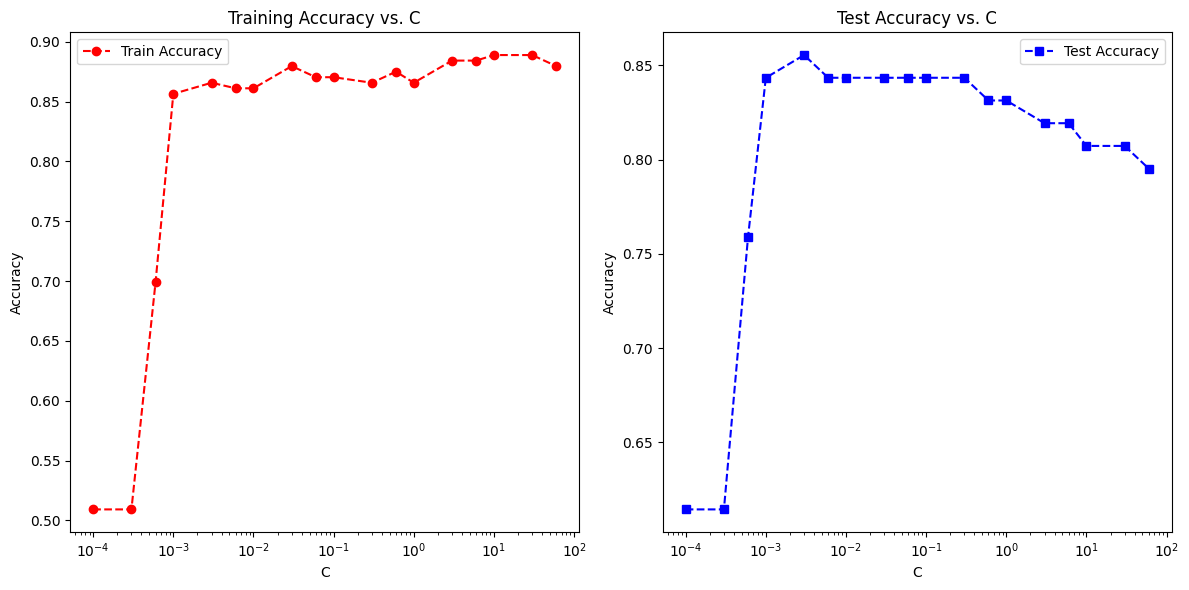

The value of C that maximizes training accuracy is: 10
The corresponding training accuracy is: 0.8888888888888888
The value of C that maximizes test accuracy is: 0.003
The corresponding test accuracy is: 0.8554216867469879


In [18]:
# Define the range of C values
C_values = [a * 10**q for a in [1, 3, 6] for q in [-4, -3, -2, -1, 0, 1]]
C_values = sorted(C_values)

train_accuracies = []
test_accuracies = []

# Calculate the optimal w, b and accuracies for each C value
for C in C_values:
    w, b, _ = trainSVM(X_train_normalized, y_train, C)
    train_acc = evalSVM(X_train_normalized, y_train, w, b)
    test_acc = evalSVM(X_test_normalized, y_test, w, b)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

# Plot the training accuracy vs. the value of C
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(C_values, train_accuracies, label='Train Accuracy', color='red', linestyle='dashed', marker='o')
plt.xscale('log')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title('Training Accuracy vs. C')
plt.legend()

# Plot the test accuracy vs. the value of C
plt.subplot(1, 2, 2)
plt.plot(C_values, test_accuracies, label='Test Accuracy', color='blue', linestyle='dashed', marker='s')
plt.xscale('log')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title('Test Accuracy vs. C')
plt.legend()

plt.tight_layout()
plt.show()

# Report the values of C that maximize the training and test accuracies
max_train_acc_index = np.argmax(train_accuracies)
max_train_acc_C = C_values[max_train_acc_index]
max_train_acc = train_accuracies[max_train_acc_index]

max_test_acc_index = np.argmax(test_accuracies)
max_test_acc_C = C_values[max_test_acc_index]
max_test_acc = test_accuracies[max_test_acc_index]

print(f"The value of C that maximizes training accuracy is: {max_train_acc_C}")
print(f"The corresponding training accuracy is: {max_train_acc}")

print(f"The value of C that maximizes test accuracy is: {max_test_acc_C}")
print(f"The corresponding test accuracy is: {max_test_acc}")